# Introducrtion to Machine Learning: Assignment #4
## Submission date: 31\07\2024, 23:55.
### Topics:
- Ensemble methods
- AdaBoost
- PCA
- LDA
- K means clustering

Submitted by:

aseel shaheen 212393532

elias badaan 212804694

**Assignment Instruction:**

· Submissions in pairs only.

· Try to keep the code as clean, concise, and short as possible

· If you wish to work in your IDE, you can, but you **must**,  insert the script back to the matching cells of the notebook and run the code. <br/>Only the notebook will be submitted in moodle (in `.ipynb` format).

· <font color='red'>Please write your answers to question in red</font>.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output). <br/>

**Important:** Your submission must be entirely your own. Any attempts of plagiarism (including ChatGPT) will lead to grade 0 and disciplinary actions.


## Question 1 - Bagging
In HW3, you helped Charles Darvin with regression of abalone problem and now, you will try combining multiple regression models instead of just one, hopefully for a better result.

In [1]:
# import libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

C:\Users\User\AppData\Local\Temp\ipykernel_16156\2590712458.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# load the data, transform it

df = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv', header=None)
data = df.to_numpy()

train, test = train_test_split(data, test_size=0.2, random_state=21)

X_train, y_train = train[:,:-1], train[:, -1]
X_test, y_test = test[:,:-1], test[:, -1]

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Your task is to complete the following bagging model. Specifically:
- fit(self, data, targets) - train n_estimators regressors, each with data in size n=len(data) that is drawn from the original data, with repititions.
- predict(self, test) - predict the result for all the regressors as learned.



In [3]:
from sklearn.linear_model import LinearRegression

class LinRegCombiner():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators    #num of estimators

    def fit(self, data, targets):
        self.regressors = []                #iniltaize list of empty estimators
        n = len(data)                       # size of data we want in each sample
        for _ in range(self.n_estimators):  # we loop on each estimator and give him randomly n samples with returns.
            idx = np.random.choice(range(n), size=n, replace=True)  #randomly choose samples with returns(some may be picked twice and some never picked)
            sampled_data, sampled_targets = data[idx], targets[idx] #save them in 2 variables as the new data for this specifec estimator.
            regressor = LinearRegression()      #create new estimator (reggresior)
            regressor.fit(sampled_data, sampled_targets)    #traing it on the data
            self.regressors.append(regressor)               #and append it to the list

    def predict(self, test):
        preds = np.zeros((test.shape[0], self.n_estimators))  #initliaze an vector of zeros to store the predictions
        for i, regressor in enumerate(self.regressors):       #loop over the estimators and get thier predictions
            preds[:, i] = regressor.predict(test)
        return np.mean(preds, axis=1)       #since its a regression problem we return the mean of the predictions

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)

In [4]:
# Run for 100 estimators

obj = LinRegCombiner(n_estimators=100)
obj.fit(X_train, y_train)

mse = obj.score(X_train, y_train)
print(f'MSE train = {mse}')

mse = obj.score(X_test, y_test)
print(f'MSE test = {mse}')

MSE train = 4.809114859371857
MSE test = 5.377746893131706


Now, implement the same but using ridge regression

In [5]:
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, RegressorMixin

class RidgeLinRegCombiner(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators, alpha=1.0):
        self.n_estimators = n_estimators
        self.alpha = alpha

    def fit(self, data, targets):
        self.regressors = []  # Initialize list of estimators
        n = len(data)  # Size of data for each sample
        for _ in range(self.n_estimators):  # Loop over each estimator
            idx = np.random.choice(range(n), size=n, replace=True)  # Randomly sample data with replacement
            sampled_data, sampled_targets = data[idx], targets[idx]  # New data for this specific estimator
            regressor = Ridge(alpha=self.alpha)  # Create new Ridge regressor
            regressor.fit(sampled_data, sampled_targets)  # Train it on the data
            self.regressors.append(regressor)  # Append it to the list

    def predict(self, test):
        preds = np.zeros((test.shape[0], self.n_estimators))  # Initialize a matrix to store predictions
        for i, regressor in enumerate(self.regressors):  # Loop over estimators to get their predictions
            preds[:, i] = regressor.predict(test)
        return np.mean(preds, axis=1)  # Return the mean of predictions for regression problem


    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)

Tune the hyperparameters for RidgeLinRegCombiner.

In [6]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

n_estimators_range = np.arange(3, 100, 1)
alpha_range =np.arange(0.01, 10.0, 20)

best_score = float('inf')
n = 0  # Best number of estimators
alpha = 0  # Best alpha value

for i in range(20):
    # Randomly select parameters from the ranges
    n_estimators = np.random.choice(n_estimators_range)
    a = np.random.choice(alpha_range)
    
    # Calculate cross-validated scores using negative mean squared error
    scores = cross_val_score(
        RidgeLinRegCombiner(n_estimators=n_estimators, alpha=a), 
        X_train, 
        y_train, 
        scoring="neg_mean_squared_error", 
        cv=kf
    )
    
    avgScore = -np.mean(scores)
    
    print(f'Iteration {i}: n_estimators={n_estimators}, alpha={a}, Average MSE: {avgScore:.4f}')
    
    if avgScore < best_score:
        best_score = avgScore
        n = n_estimators  # Store the best n_estimators
        alpha = a  # Store the best alpha

# Output the best hyperparameters
print(f'Best hyperparameters: n_estimators={n}, alpha={alpha} with MSE {best_score:.4f}')

Iteration 0: n_estimators=52, alpha=0.01, Average MSE: 4.9418
Iteration 1: n_estimators=13, alpha=0.01, Average MSE: 4.9736
Iteration 2: n_estimators=95, alpha=0.01, Average MSE: 4.9287
Iteration 3: n_estimators=4, alpha=0.01, Average MSE: 4.9478
Iteration 4: n_estimators=4, alpha=0.01, Average MSE: 4.9421
Iteration 5: n_estimators=15, alpha=0.01, Average MSE: 4.9410
Iteration 6: n_estimators=5, alpha=0.01, Average MSE: 4.9210
Iteration 7: n_estimators=43, alpha=0.01, Average MSE: 4.9174
Iteration 8: n_estimators=31, alpha=0.01, Average MSE: 4.9464
Iteration 9: n_estimators=41, alpha=0.01, Average MSE: 4.9368
Iteration 10: n_estimators=18, alpha=0.01, Average MSE: 4.9340
Iteration 11: n_estimators=21, alpha=0.01, Average MSE: 4.9356
Iteration 12: n_estimators=7, alpha=0.01, Average MSE: 4.9322
Iteration 13: n_estimators=45, alpha=0.01, Average MSE: 4.9465
Iteration 14: n_estimators=99, alpha=0.01, Average MSE: 4.9231
Iteration 15: n_estimators=75, alpha=0.01, Average MSE: 4.9226
Iterat

Print both MSEs on train and test.
Which model is better for our problem? <br/>
<font color='red'>Write your answer here and explain it
<br><br>

Ridge Regression bagging proves to be more effective in our case, as it resulted in a lower MSE on the test set, indicating better generalization to new data. Additionally, the slightly higher MSE on the training set suggests an increase in regularization, which helps prevent overfitting.althought diffrenet running may result in diffrenet conclusions and results.
</font>

In [14]:
# Run for n estimators and alpha you found

obj = RidgeLinRegCombiner(n_estimators=n, alpha=alpha)
obj.fit(X_train, y_train)

mse = obj.score(X_train, y_train)
print(f'MSE train = {mse}')

mse = obj.score(X_test, y_test)
print(f'MSE test = {mse}')

MSE train = 4.806277906430965
MSE test = 5.378376378829903


## Question 2 - Clustering

We learned in the tutorials about partitional clustering and specifically – k means algorithm. <br/>
In this question you will implement it and see some nice applications.

import libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Complete the missing implementation of Kmeans. Since there are k clusters, we will label each point with {0,..,k-1}.

In [10]:
class Kmeans:

	def __init__(self, n_clusters, max_iter=100, random_state=123):
		self.n_clusters = n_clusters
		self.max_iter = max_iter
		self.random_state = random_state

	def initialize_centroids(self, X):
		np.random.RandomState(self.random_state)
		random_idx = np.random.permutation(X.shape[0])
		centroids = X[random_idx[:self.n_clusters]]
		return centroids

	def reassign_centroids(self, X, labels):
		centroids = np.zeros((self.n_clusters, X.shape[1]))	# initlaize k  zeros centers
		for k in range(self.n_clusters):					#we loop over the data in each cluster from the iniliaztion and calc the mean of the data
			centroids[k, :] = np.mean(X[labels == k], axis=0)# which will be the new centeriods
		return centroids

	def compute_distance(self, X, centroids):
		distance = np.zeros((X.shape[0], self.n_clusters))
		for k in range(self.n_clusters):
			row_norm = np.linalg.norm(X - centroids[k, :], axis=1)
			distance[:, k] = np.square(row_norm)
		return distance

	def find_closest_cluster(self, distance):
		return np.argmin(distance, axis=1)

	def compute_sse(self, X, labels, centroids):
		distance = np.zeros(X.shape[0])
		for k in range(self.n_clusters):
			distance[labels == k] = np.linalg.norm(X[labels == k] - centroids[k], axis=1)
		return np.sum(np.square(distance))

	def fit(self, X):
		self.centroids = self.initialize_centroids(X)
		for i in range(self.max_iter):
			old_centroids = self.centroids.copy()		#?	get the old centers
			#? calc the distance between the data and the centers
			distance = self.compute_distance(X, self.centroids)
			#? get the closest cluster to each data point
			self.labels = self.find_closest_cluster(distance)
			#? reassign the centers based on the new clusters
			self.centroids = self.reassign_centroids(X, self.labels)
			# Check for convergence
			if np.all(old_centroids == self.centroids):
				break

		self.error = self.compute_sse(X, self.labels, self.centroids)

	def predict(self, X):
		distance = self.compute_distance(X, self.centroids)
		return self.find_closest_cluster(distance)

Load exams data, convert to numpy and plot it

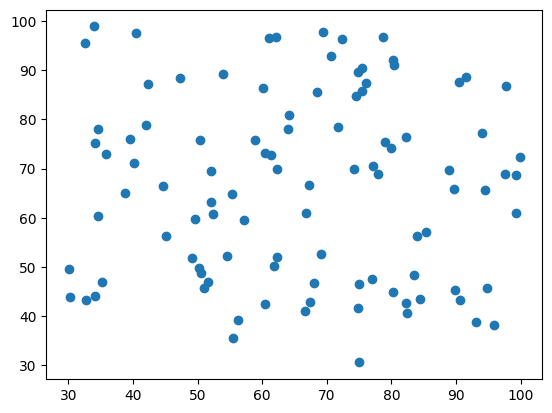

In [11]:
db = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw4/exams.csv', header=None).to_numpy()
data, labels = db[:,:-1], db[:,-1]

plt.scatter(data[:, 0], data[:, 1])
plt.show()

We are going to divide the data into 2 clusters. <br/>
Define Kmeans object and fit the data.

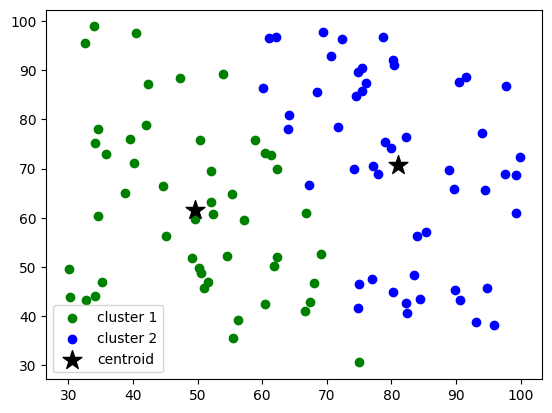

In [18]:
clust = Kmeans(n_clusters=2)
clust.fit(data)

# This code plots the clustered data with centroids
labels = clust.labels
centroids = clust.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]

plt.scatter(c0[:,0], c0[:,1], c='green', label='cluster 1')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()

plt.show()

Use the Elbow Method to choose another number of centroids between 1-10. <br/>
<font color='red'>Explain your choice<br><br>
We can observe from the graph that from k=1 to k=4 we see an big jump in the sum square of distances,
and afterwads the change become more minor which indicates that the best possible k is 4.
</font>

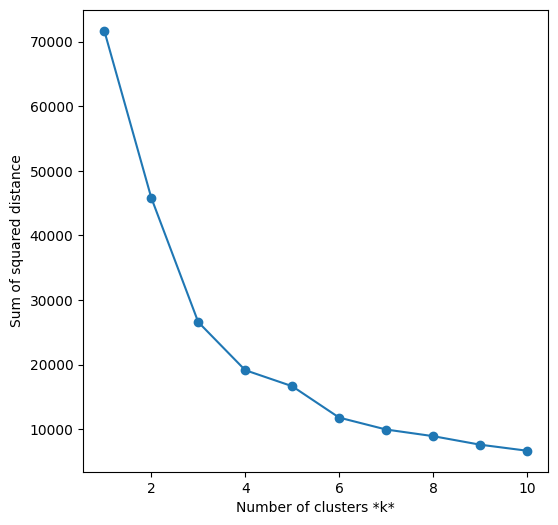

In [13]:
sse = []
list_k = list(range(1, 11))

for k in list_k:
    kmeans = Kmeans(n_clusters=k)
    kmeans.fit(data)
    sse.append(kmeans.error)


'''Plot sse against k'''
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

Apply clustering with the selected k

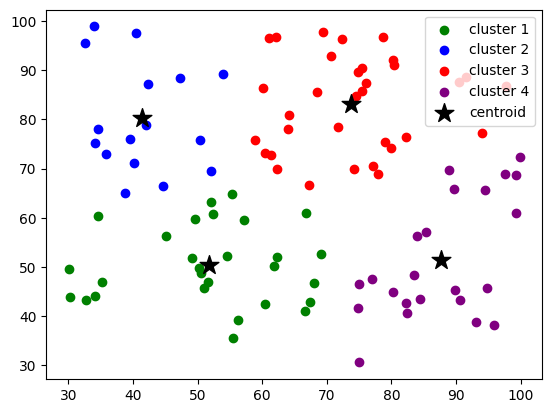

In [19]:
clust = Kmeans(n_clusters=4)
clust.fit(data)

# Updated code to plot the clustered data with centroids for k=4
labels = clust.labels
centroids = clust.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]
c2 = data[labels == 2]
c3 = data[labels == 3]  # Additional cluster for k=4

plt.scatter(c0[:, 0], c0[:, 1], c='green', label='cluster 1')
plt.scatter(c1[:, 0], c1[:, 1], c='blue', label='cluster 2')
plt.scatter(c2[:, 0], c2[:, 1], c='red', label='cluster 3')
plt.scatter(c3[:, 0], c3[:, 1], c='purple', label='cluster 4')  # Plotting the new cluster
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()


plt.show()

Now, you will compress some image using k-means. <br/>
Here, you are given image from size 400x600x3. The last parameter is the number of channels. 3 channels means that the image is colored (unlike 1 in, which is grayscale). <br/>
Our goal is to reduce the number of colors to 20 and represent (compress) the photo using those 20 colors only. <br/>

Motivation: the original image requires 400x600x3x8 bits, while the new image will require only 400x600x5 + 20x24 bits, almost 5 times smaller!<br/>
To really do this, we will take the image and treat every pixel as a data point, where each data point is in 3d space (r,g,b). Then, we cluster into 20 centroids, and we assign each pixel to a centroid. This will allow us to represent the image using only 20 colors.


In [15]:
#@title helper function

import urllib.request

def read_image(url):
    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    return cv2.imdecode(arr, -1)

Complete the missing code

In [16]:
from sklearn.cluster import KMeans
import cv2

img = read_image('https://sharon.srworkspace.com/ml/datasets/hw4/image.jpg')
img_size = img.shape

# Reshape it to be 2-dimension
X = img.reshape(img_size[0] * img_size[1], img_size[2])		# Turn hxwx3 into (h*w)x3

# Run the Kmeans algorithm
km = KMeans(n_clusters=20)
km.fit(X)

'''
The km has the following properties:
(*) km.labels_ is an array size (pixels, 20), will give each pixel its class from 20 classes (values are between 0-19)
(*) km.cluster_centers_ is an array size 20x3, where the ith row represents the color value for the ith label.
	For example, cluster_centers_[0] = [r,g,b], the first center.
'''

# Use the centroids to compress the image
img_compressed = km.cluster_centers_[km.labels_]
img_compressed = np.clip(img_compressed.astype('uint8'), 0, 255)

# Reshape X_recovered to have the same dimension as the original image 128 * 128 * 3'''
img_compressed = img_compressed.reshape(img_size[0], img_size[1], img_size[2])

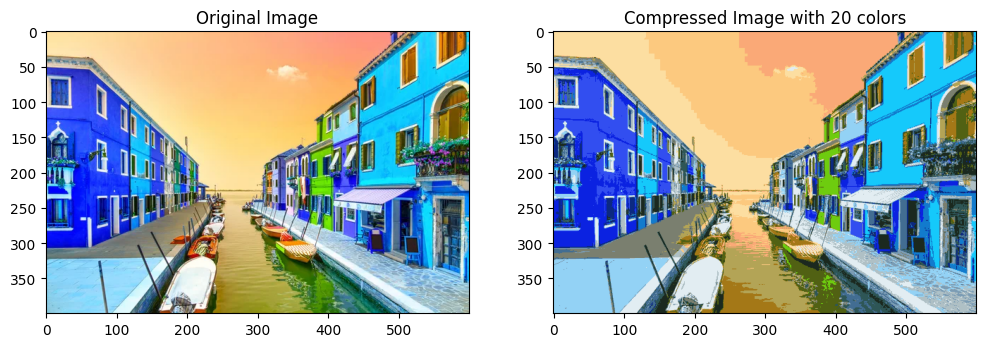

In [17]:

# Plot the original and the compressed image next to each other'''
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_compressed)
plt.title(f'Compressed Image with {km.n_clusters} colors')

plt.show()

## load smiling dataset

In the third question, we will deal with the Smiling-face dataset, which determines if a person is smiling or not. You will try several models and hope to get good results<br/>
Your task is: run the following section and make sure your understand what's going on.

Go to your <a href="https://www.kaggle.com/">Kaggle</a> account and under the settings, generate new API token. <br/>
This will give you the json file, which you will upload here.

In [ ]:
# The script expects you to upload JSON file to it!

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download chazzer/smiling-or-not-face-data
! unzip -q smiling-or-not-face-data.zip -d data

Saving kaggle.json to kaggle.json
ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datazng/shopping-mall-customer-data-segmentation-analysis  Shopping Mall Customer Data Segmentation Analysis    6MB  2024-08-04 20:36:31           1066         32  0.88235295       
myrios/cost-of-living-index-by-country-by-number-2024      Cost of Living Index by Country                      3KB  2024-07-19 06:25:42           1923         22  1.0              
waqi786/cats-dataset                                       🐾 Cats Dataset                                       6KB  2024-07-31 06:12:49           2005         42  1.0              
abhayayare/employee-data-simulation-it-industry         

import libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

process the images

In [ ]:
def proccess_data(folder):
	image_arrays = []
	for filename in os.listdir(folder):
		file_path = os.path.join(folder, filename)
		image = cv2.imread(file_path)
		gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image_arrays.append(gray_image)
	return np.array(image_arrays)

smile = proccess_data('./data/smile')
non_smile = proccess_data('./data/non_smile')

dataset = np.vstack((smile,non_smile))
dataset = dataset / 255

labels = [0] * len(smile) + [1] * len(non_smile)
labels = np.array(labels)

display smiling and non-smiling image.

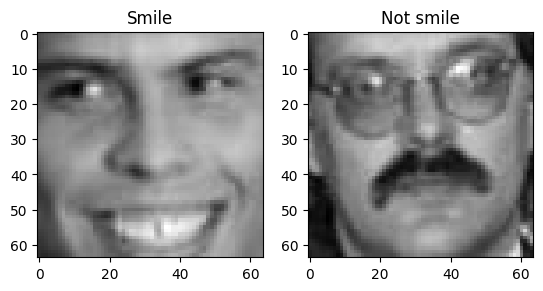

In [ ]:
plt.subplot(121)
plt.title("Smile")
plt.imshow(smile[0], cmap='gray')

plt.subplot(122)
plt.title("Not smile")
plt.imshow(non_smile[0], cmap='gray')

plt.show()

print the smiling and non-smiling data + the united dataset along with labels.

In [ ]:
print(f'smile array size is (images, height, width)={smile.shape}')
print(f'non smile array size is (images, height, width)={non_smile.shape}')
print()
print(f'dataset array size is {dataset.shape}')
print(f'labels array size is {labels.shape}')

smile array size is (images, height, width)=(600, 64, 64)
non smile array size is (images, height, width)=(603, 64, 64)

dataset array size is (1203, 64, 64)
labels array size is (1203,)


Prepear train and test datasets, print their structure. Since you have to deal with 1d features, we flatten the squared image

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.2, stratify=labels, random_state=42)

print(f'train size is {x_train.shape} and labels size is {y_train.shape}')
print(f'test size is {x_test.shape} and labels size is {y_test.shape}')
print()

x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print(f'flattened train size is {x_train_flatten.shape} ')
print(f'flattened test size is {x_test_flatten.shape}')

train size is (962, 64, 64) and labels size is (962,)
test size is (241, 64, 64) and labels size is (241,)

flattened train size is (962, 4096) 
flattened test size is (241, 4096)


## Question 3 - PCA, LDA

You will try to classify the smiling faces dataset using feature reduction and KNN (since there are 4096 features!). Than you will compare it to LDA

import libraries

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

Implement PCA to reduce the dimension of the images from 4096=64x64 to 81=9x9. For time effciency, DONT use any loops here.

Hint: Implement inverse_transform to recover the original vector from the compressed one. <br/>
Hint: When dealing with symmetric matrix, you can call eigh instead of eig function of numpy, its much faster.

In [ ]:
def PCA_train(data, k):
    data_array = np.array(data)
    mean_vector = data_array.mean(axis=0)
    centered_data = data_array - mean_vector
    scatter_matrix = np.matmul(centered_data.T, centered_data)# Compute the scatter matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(scatter_matrix)
    # Sort the eigenvalues and eigenvectors in descending order
    indices_sorted = np.argsort(eigen_vals)[::-1]
    eigen_vals_sorted = eigen_vals[indices_sorted]
    eigen_vecs_sorted = eigen_vecs[:, indices_sorted]

    top_eigenvectors = eigen_vecs_sorted[:, :k]# Select the top 'k' eigenvectors

    # Project the data onto the new feature space
    reduced_data = (np.matmul(top_eigenvectors.T, centered_data.T)).T

    return np.real(reduced_data), mean_vector, top_eigenvectors,eigen_vals_sorted


def PCA_test(test, mu, E):
    centered_test_data = test - mu
    # Project the test data onto the PCA space
    projected_test_data = (np.matmul(E.T, centered_test_data.T)).T

    return np.real(projected_test_data)


def recover_PCA(data, mu, E):
    # Reconstruct the original data from the PCA-transformed data
    original_data = np.dot(data, E.T) + mu

    return np.real(original_data)


Apply the PCA. <br/>
Make sure you fit the PCA model only to the training set (but apply it to both training and test sets). <br/>

In [ ]:
k = 81

# Train PCA on the training data
x_train_new, mu, eig,val = PCA_train(x_train_flatten, k)

# Transform the test data using PCA
x_test_new = PCA_test(x_test_flatten, mu, eig)



Pick another random image and show the result of applying PCA to it, and then try to recover the whole size again.

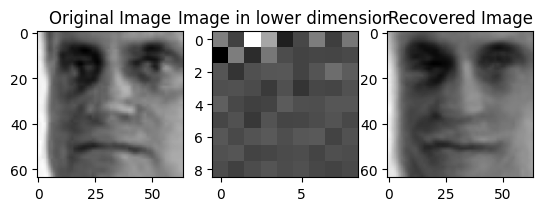

In [ ]:
# Original image
original = x_train[1].reshape(64,64)
compressed = x_train_new[1]
square = compressed.reshape(9,9)

# Recover the original size
recovered = recover_PCA(compressed, mu, eig)
recovered_square = recovered.reshape(64,64)

plt.subplot(131)
plt.title("Original Image")
plt.imshow(original, cmap='gray')

plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(square, cmap='gray')

plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(recovered_square, cmap='gray')

plt.show()

Before training the model, use EIG_CDF, that given eigenvalues, draws a CDF of them like here:<br/><br/>

![Picture1.jpg](https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcS3mOZk1x4X3ap9nuMnst5W5pMgOXF8r3Tmx1QcFX9mba_lleuB)

As seen in the tutorials, we use them to see how much "energy" we preserve from the data. Use this to choose optimal dimension to reduce into, such the preserves 95% of the energy.

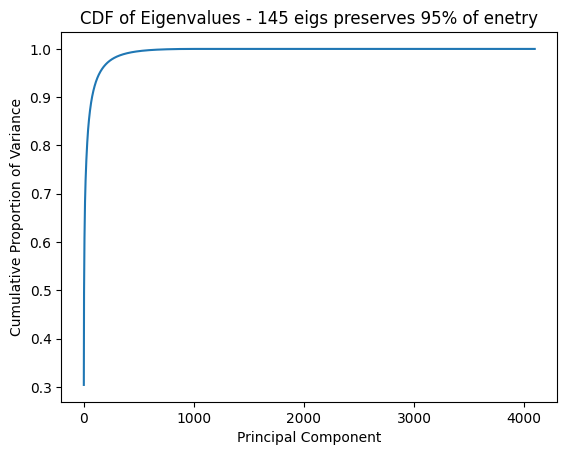

In [ ]:
def EIG_CDF(eig_list):
	sorted_eigenvalues = np.sort(eig_list)[::-1]

	eigenvalues_cumsum = np.cumsum(sorted_eigenvalues)

	eigenvalues_cumsum_normalized = eigenvalues_cumsum / eigenvalues_cumsum[-1]
	amount = np.argmax(eigenvalues_cumsum_normalized >= 0.95) + 1

	plt.plot(np.arange(1, len(sorted_eigenvalues)+1), eigenvalues_cumsum_normalized)
	plt.xlabel('Principal Component')
	plt.ylabel('Cumulative Proportion of Variance')
	plt.title(f'CDF of Eigenvalues - {amount} eigs preserves 95% of enetry')
	plt.show()

EIG_CDF(val)

For the same image as before, show the result of applying PCA to it and recovering.<br/>
Is the result better? What is different from 81 dimensions? <br/>
<font color='red'> when applying PCA and recovering we can see better results,improvments in image quality, calrity and we can also note that the image retained infomation resulting in finer details in the face so that all the detail in the face appear to be all around clearer.   </font>

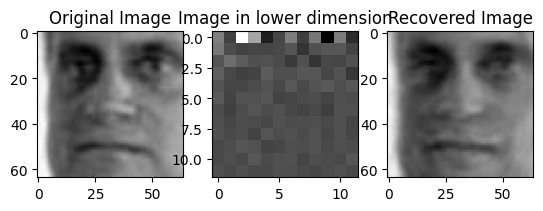

In [ ]:
x_train_new2, mu2, eig2, val2 = PCA_train(x_train_flatten, 144)
x_test_new2 = PCA_test(x_test_flatten, mu2, eig2)
original = x_train[1].reshape(64, 64)
plt.subplot(131)
plt.title("Original Image")
plt.imshow(original, cmap='gray')
compressed = x_train_new2[1].reshape(12, 12)
compressed = np.real(compressed)

plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(compressed, cmap='gray')

compressed_1d = compressed.flatten()
recovered = recover_PCA(compressed_1d, mu2, eig2)
recovered = np.real(recovered)
recovered_square = recovered.reshape(64,64)

plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(recovered_square, cmap='gray')

plt.show()


Now, you are ready to train the model. Use KNN, tune the best k using cross_val_score (with sklearn)

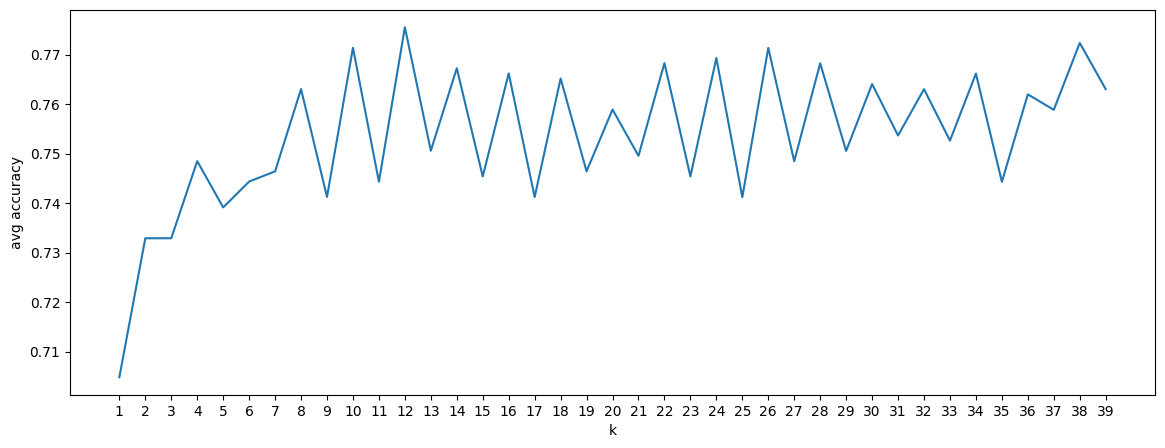

In [ ]:
# Implement here
accs = []
max_avg_acc =0
ks = range(1, 40)

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train_flatten, y_train, cv=5, scoring='accuracy')
    accs.append(scores.mean())

plt.figure(figsize=(14,5))
plt.plot(ks, accs)
plt.xlabel('k')
plt.xticks(ks)
plt.ylabel('avg accuracy')
plt.show()

Print the accuracy of your model on the test set.

In [ ]:
# Implement here
best_k = ks[np.argmax(accs)]

# Train the KNN model with the best value of k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(x_train_flatten, y_train)

# Evaluate the model on the test set
acc = best_knn.score(x_test_flatten, y_test)
print(f'acc on test is {acc}')

acc on test is 0.7717842323651453


Answer the following sum-up questions: <br/>
- What pre-proccessing actions were done on the data?
- Should we apply Standard Scaler? Why?
- Suggest one idea for improvement (rather than LDA)

<font color='red'>- What pre-proccessing actions were done on the data?<br/>
1.Each loaded image was converted from RGB to greyscale.
<br/>
2.We split the dataset into two sets trainnig and testing.
<br/>
3.Each image was flattened into a 1D array wich is neccesary for applying PCA.
<br/>
also we gave labels to images and did zero centering
<br/>
-Should we apply Standard Scaler? Why?
<br/>
 PCA is sensitive to the variance of features, scaling helps ensure that PCA accurately captures directions of maximum variance. Even though pixel values are uniformly scaled, applying Standard Scaler before PCA can help center the data around zero and standardize variance, potentially improving PCA's effectiveness.in this case, scaling is not strictly necessary due to the uniform pixel scale, but it could enhance PCA's performance by ensuring all features contribute equally.
 <br/>
-Suggest one idea for improvement:
<br/>
Kernel PCA allows for non-linear dimensionality reduction by applying kernel methods. This can capture more complex structures in the data that linear PCA might miss, especially when dealing with image data that might have intricate patterns not aligned linearly.

</font>


For the second part, we will use LDA on the data <b>before</b> PCA. <br/>
Use the model of LinearDiscriminantAnalysis from Sklearn, train the data and print the accuracy test using KNN. <br/>
Use the best k you found earlier.

In [ ]:

# Apply LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=min(len(np.unique(y_train)) - 1, 144))  # Use min to handle class size
x_train_lda = lda.fit_transform(x_train_flatten, y_train)
x_test_lda = lda.transform(x_test_flatten)

# Train KNN with the best k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(x_train_lda, y_train)

# Test accuracy with LDA alone
acc_lda = best_knn.score(x_test_lda, y_test)
print(f"LDA Alone Accuracy: {acc_lda:.2f}")
#####################################################
# Apply LDA on PCA-reduced data

lda = LinearDiscriminantAnalysis(n_components=min(len(np.unique(y_train)) - 1, 144))
x_train_pca_lda = lda.fit_transform(x_train_new2, y_train)
x_test_pca_lda = lda.transform(x_test_new2)

# Train KNN with the best k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(x_train_pca_lda, y_train)

# Test accuracy with PCA + LDA
acc_pca_lda = best_knn.score(x_test_pca_lda, y_test)
print(f"PCA + LDA Accuracy: {acc_pca_lda:.2f}")



LDA Alone Accuracy: 0.72
PCA + LDA Accuracy: 0.88


Now, repeat the same as above, but using the data <b>after</b> PCA and using the same k.
- Was the combination of PCA and LDA helpful more than LDA alone?
- Comparing LDA alone vs PCA alone (as dimensionality reduction), which one was better to this problem? Justify.

<font color='red'>

Was the combination of PCA and LDA helpful more than LDA alone?
<br/>
Yes, the combination of PCA and LDA was more helpful, as it achieved a higer accuracy LDA alone.That is becuase PCA effectively reduced noise and redundancy, allowing LDA to focus on the most informative features for class separation.
<br/>
Comparing LDA Alone vs. PCA Alone (as Dimensionality Reduction), Which One Was Better for This Problem? Justify.
<br/>
Combining PCA and LDA was better for this problem as we took advantage of the strengths of both methods ,PCA reduced dimensionality and noise, enhancing LDA's ability to separate classes effectively.
LDA focuses on class separation, it benefited from PCA's preprocessing, which provided a cleaner and more informative dataset for LDA to work with.but if we compare between PCA and LDA we can see that PCA is giving a better result.
</font>

## Question 4 - Adaboost
See attached pdf in moodle assignment!



## Question 5 - Kernel PCA - 10 pts bonus
See attached pdf in moodle assignment! <br/>
Here you will implement the parts that are relevant for that question

In [ ]:
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Apply Kernel PCA
kpca = KernelPCA(n_components=144, kernel='cosine')
x_train_kpca = kpca.fit_transform(x_train_flatten)
x_test_kpca = kpca.transform(x_test_flatten)
knn = KNeighborsClassifier(n_neighbors=125)
knn.fit(x_train_kpca, y_train)

y_pred_kpca = knn.predict(x_test_kpca)
acc_kpca = accuracy_score(y_test, y_pred_kpca)

print(f"Kernel PCA with 'cosine' kernel Accuracy: {acc_kpca:.2f}")

Kernel PCA with 'cosine' kernel Accuracy: 0.83
